In [1]:
import os
os.chdir('../')
current_directory = os.getcwd()
print("Current Directory:", current_directory)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np


import warnings; 
warnings.simplefilter('ignore')

Current Directory: c:\Users\Darren Chong\Documents\School\Thesis B\Spectrogram-Based-Omics-Imagification


In [2]:
expr_file = r"./data/TCGA/curatedTCGAData_RNASeq2GeneNorm.txt"
expr = pd.read_csv(expr_file, sep="\t")
y = expr['cancer'].values
X = expr.iloc[:, 2:].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y)


In [3]:
def scaler_fit(X: np.ndarray) -> tuple:
    """Compute parameters needed for log normalization and scaling."""
    min0 = X.min(axis=0)
    max_val = np.log(X + np.abs(min0) + 1).max()
    return min0, max_val

def scaler_transform(X: np.ndarray, min0: np.ndarray, max_val: float) -> np.ndarray:
    """Apply log normalization and scaling to the input data."""
    X_norm = np.log(X + np.abs(min0) + 1).clip(0, None)
    return (X_norm / max_val).clip(0, 1)

def scaler_fit_transform(X: np.ndarray) -> np.ndarray:
    """Combine fitting and transforming steps."""
    min0, max_val = scaler_fit(X)
    return (scaler_transform(X, min0, max_val), min0, max_val)

(X_train_norm, min0, max_val) = scaler_fit_transform(X_train)
X_test_norm = scaler_transform(X_test, min0, max_val)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = np.unique(y_train_enc).size

Training Accuracy: 1.0
Test Accuracy: 0.9880382775119617
Precision (Macro): 0.9860841135967335
Precision (Micro): 0.9880382775119617
Precision (Weighted): 0.9880089387056347
Recall (Macro): 0.985935666275472
Recall (Micro): 0.9880382775119617
Recall (Weighted): 0.9880382775119617
F1-score (Macro): 0.9859837663235721
F1-score (Micro): 0.9880382775119617
F1-score (Weighted): 0.9880010229890612
ROC-AUC (OvO, Macro): 0.9415749665290928
ROC-AUC (OvO, Weighted): 0.941618261031986


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       219
           1       0.99      0.99      0.99       104
           2       0.98      1.00      0.99       107
           3       1.00      1.00      1.00       103
           4       0.96      0.96      0.96       103
           5       0.97      0.95      0.96       100
           6       1.00      1.00      1.00       100

    accuracy                           0.99       836
   macro avg       0.99      0.

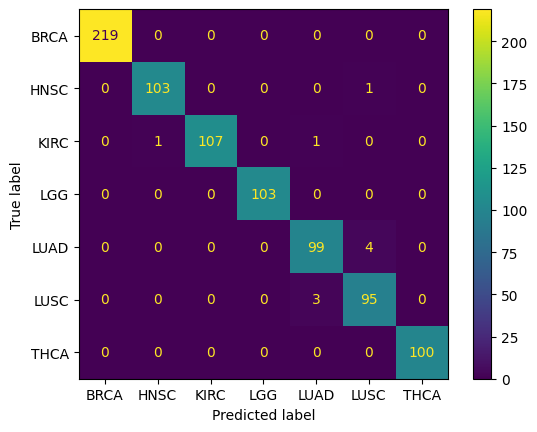

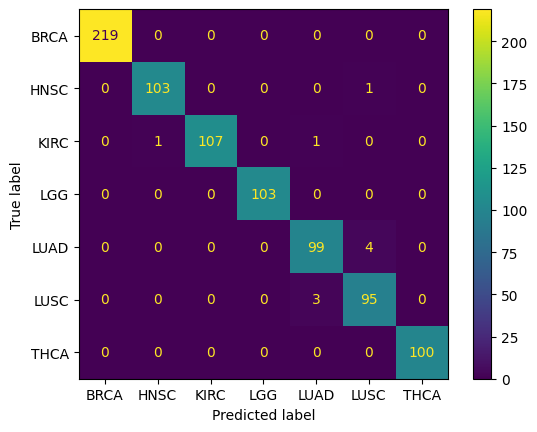

In [4]:
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

clf = svm.SVC(kernel='linear', probability=True)
clf.fit(X_train_norm, y_train_enc)
y_pred = clf.predict(X_test_norm)
# Calculate evaluation metrics
precision_macro = precision_score(y_test_enc, y_pred, average='macro')
precision_micro = precision_score(y_test_enc, y_pred, average='micro')
precision_weighted = precision_score(y_test_enc, y_pred, average='weighted')
recall_macro = recall_score(y_test_enc, y_pred, average='macro')
recall_micro = recall_score(y_test_enc, y_pred, average='micro')
recall_weighted = recall_score(y_test_enc, y_pred, average='weighted')
f1_macro = f1_score(y_test_enc, y_pred, average='macro')
f1_micro = f1_score(y_test_enc, y_pred, average='micro')
f1_weighted = f1_score(y_test_enc, y_pred, average='weighted')
roc_auc_macro = roc_auc_score(y_test_enc, clf.predict_proba(X_test), average='macro', multi_class='ovo')
roc_auc_weighted = roc_auc_score(y_test_enc, clf.predict_proba(X_test), average='weighted', multi_class='ovo')
# Classification report (includes precision, recall, F1-score, support)
report = classification_report(y_test_enc, y_pred)

train_accuracy = accuracy_score(y_train_enc, clf.predict(X_train_norm))

# Calculate test accuracy
test_accuracy = accuracy_score(y_test_enc, y_pred)


print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Precision (Macro):", precision_macro)
print("Precision (Micro):", precision_micro)
print("Precision (Weighted):", precision_weighted)
print("Recall (Macro):", recall_macro)
print("Recall (Micro):", recall_micro)
print("Recall (Weighted):", recall_weighted)
print("F1-score (Macro):", f1_macro)
print("F1-score (Micro):", f1_micro)
print("F1-score (Weighted):", f1_weighted)
print("ROC-AUC (OvO, Macro):", roc_auc_macro)
print("ROC-AUC (OvO, Weighted):", roc_auc_weighted)
print("\n")
print(report)
disp = ConfusionMatrixDisplay.from_predictions(y_pred, y_test_enc, display_labels=le.classes_)
disp.plot()